# 测试颜色的代码

In [3]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
colorslist = ['gray','aqua','#0343df','lime']
cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=4)




Cloud
查看数据 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the buil

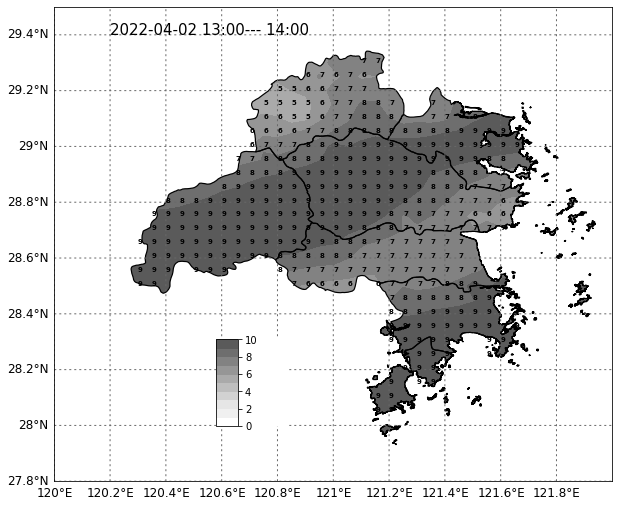

In [11]:
# coding=UTF-8
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
import netCDF4 
# import h5netcdf.legacyapi as netCDF4
import h5py
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
import os
from datetime import *

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

basicfile = '/home/liyuan3970/Data/My_Git/web_met/'

class plot_tz_product:
    def __init__(self, plot_type,plot_time):
        self.plot_time = plot_time
        self.plot_type = plot_type
        self.time_len = 0
        self.lat,self.lon,self.time,self.data_xr_nc,self.date,self.u,self.v  = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    
    def makedegreelabel(self,degreelist):
        labels=[str(x)+u'°E' for x in degreelist]
        return labels        
    def read_data(self):
        os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
        file_path = basicfile + "/static/data/TZ_self/"        
        # file_name = file_path +"20220401/"+'I20220401080000.'+self.plot_type+'.nc'
        file_name = file_path +"20220402/"+'I20220402080000.'+self.plot_type+'.nc'
        # f = xr.open_dataset(file_name)
        f = netCDF4.Dataset(file_name,"r",format="NETCDF4")
        data_xr_u = None
        data_xr_v = None
        data_xr_nc = None
        print(str(self.plot_type))
        if str(self.plot_type) =="WindEx":  
            data_xr_u = f.variables['U']
            data_xr_v = f.variables['V']        
        elif str(self.plot_type) =="WindEx12":  
            data_xr_u = f.variables['U']
            data_xr_v = f.variables['V']
        else:
            data_xr_nc = f.variables[str(self.plot_type)]
            
        
        lat = f.variables['lat'][:]
        lon = f.variables['lon'][:]
        time = f.variables['time'][:]
        date = "20220402"
        self.time_len = len(time)        
        return lat,lon,time,data_xr_nc,date,data_xr_u,data_xr_v
    def plot_img(self,item):
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        # 添加最大值和最小值
        
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = basicfile+"/static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {
        #'orientation': 'horizontal',
        # 'label': 'Potential',
        'shrink': 0.5,
        }
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=True)
        # position=fig.add_axes([0.15, 0.05, 0.7, 0.03])#位置[左,下,右,上]
        # m.colorbar?
        
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False' )
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd        
    def multy_plot(self):
        '''返回图片列表'''
        imd_list = []
        time_list = []
        for i in range(self.time_len):
            imd,time = self.plot_img(i)
            imd_list.append(imd)
            time_list.append(time)
        return imd_list,time_list
    def temperture(self,item):
        '''绘制逐小时的气温'''
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        # 添加最大值和最小值
        cmaps ,levels = self.colormap(self.plot_type)
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = basicfile+"/static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "country")
        awash_da = shp_da.where(shp_da.country<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,add_labels=True)
        # position=fig.add_axes([0.15, 0.05, 0.7, 0.03])#位置[左,下,右,上]
        # m.colorbar?
        ##########标题#############################
        label, start_time  = self.label_text(self.plot_type,item)
        plt.text(120.2,29.4, label,fontsize=15)
        ##########标题#############################
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False' )
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd,str(start_time)[:16]
    def colormap(self,plot_type):
        '''色标的自定义'''
        # 可选用的绘图类型  
        ## 降水
#         colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
#         cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
#         levels = [0,1,2,3,4,5,6,7]
        ## 云量
#         colorslist = ['#FFFFFF',"#F0F0F0","#E6E6E6","#D2D2D2","#BEBEBE","#AAAAAA","#969696","#828282","#6E6E6E","#5A5A5A"]# CLOUND
#         cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=10)
#         levels = [0,1,2,3,4,5,6,7,8,9,10]
        ## 气温
#         colorslist = ["#264FC7","#286BD9","#2B87EB","#2EA4FD","#48BBF0","#62D3E3","#7DEBD7","#9CEFC0","#BBF3A9","#DBF792","#E7E07C","#F3CB66","#FFB551","#FFBB6A","#FFC184","#FFC89E","#FFDABE","#FFECDE","#FFFFFF"]# CLOUND
#         cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=19)
#         levels = [6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]    
        if plot_type =="T":
            # 短期气温
            colorslist = ["#264FC7","#286BD9","#2B87EB","#2EA4FD","#48BBF0","#62D3E3","#7DEBD7","#9CEFC0","#BBF3A9","#DBF792","#E7E07C","#F3CB66","#FFB551","#FFBB6A","#FFC184","#FFC89E","#FFDABE","#FFECDE","#FFFFFF"]# CLOUND
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=19)
            levels = [6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40] 
        elif plot_type =="Pr01":
            # 短期降水
            colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
            levels = [0,1,2,3,4,5,6,7]
        elif plot_type =="Pr24":
            # 降水
            colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
            levels = [0,1,2,3,4,5,6,7]
        elif plot_type =="TMax24":
            # 高温
            colorslist = ["#264FC7","#286BD9","#2B87EB","#2EA4FD","#48BBF0","#62D3E3","#7DEBD7","#9CEFC0","#BBF3A9","#DBF792","#E7E07C","#F3CB66","#FFB551","#FFBB6A","#FFC184","#FFC89E","#FFDABE","#FFECDE","#FFFFFF"]# CLOUND
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=19)
            levels = [6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40] 
        elif plot_type =="TMin24":
            # 低温
            colorslist = ["#264FC7","#286BD9","#2B87EB","#2EA4FD","#48BBF0","#62D3E3","#7DEBD7","#9CEFC0","#BBF3A9","#DBF792","#E7E07C","#F3CB66","#FFB551","#FFBB6A","#FFC184","#FFC89E","#FFDABE","#FFECDE","#FFFFFF"]# CLOUND
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=19)
            levels = [6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40] 
        elif plot_type =="Cloud":
            colorslist = ['#FFFFFF',"#F0F0F0","#E6E6E6","#D2D2D2","#BEBEBE","#AAAAAA","#969696","#828282","#6E6E6E","#5A5A5A"]# CLOUND
            cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=10)
            levels = [0,1,2,3,4,5,6,7,8,9,10]
        return cmaps,levels
    def label_text(self,plot_type,item):
        '''图题'''
        if plot_type in ["T","Pr01","Cloud"]:
            # 逐小时
            print("查看数据",item)
            start_year = int(self.date[0:4])
            start_month = int(self.date[4:6])
            start_day = int(self.date[6:8])   
            init_time = datetime(start_year, start_month, start_day, int(self.plot_time), 0, 0)
            start_hours = int(self.time[item]-1)
            start_time = init_time + timedelta(hours = start_hours)
            end_time =  start_time + timedelta(hours = 1)
            label = str(start_time)[:16] + "---" + str(end_time)[10:16]
        else:
            # 每天
            start_year = int(self.date[0:4])
            start_month = int(self.date[4:6])
            start_day = int(self.date[6:8])   
            init_time = datetime(start_year, start_month, start_day, int(self.plot_time), 0, 0)
            start_hours = int(self.time[item]-1)
            start_time = init_time + timedelta(hours = start_hours)
            end_time =  start_time + timedelta(hours = 24)
            label = str(start_time)[:16] + "---" + str(end_time)[10:16]
        return label, start_time       

        
        

plot_type, plot_time = 'Cloud','08'
product = plot_tz_product(plot_type, plot_time)

img,time = product.temperture(5)


In [ ]:
# 

# ec数据的测试

In [1]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import datetime
import math
class ec_data_point:
    def __init__(self, select_time,select_type,select_lat,select_lon): 
        self.var_list = ['u10','v10','tcc','t2','skt','lsp','cp','tp','r'] # 风向风速、云量、温度、tp（总降水）、相对湿度
        self.data = { }
        self.read_data()
    # 创建对象读取io的核心代码####################################################################
    def regrid_data(self,data):
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
        f = xr.open_mfdataset(file_path, parallel=False)
        # 列表数据--
        u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
        v10 = f.v10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        v10 =  v10.swap_dims({'latS':'lat','lonS':'lon'})
        tcc = f.tcc.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        tcc =  tcc.swap_dims({'latS':'lat','lonS':'lon'})
        t2 = f.t2.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        t2 =  t2.swap_dims({'latS':'lat','lonS':'lon'})
        skt = f.skt.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        skt =  skt.swap_dims({'latS':'lat','lonS':'lon'})
        lsp = f.lsp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        lsp =  lsp.swap_dims({'latS':'lat','lonS':'lon'})
        cp = f.cp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        cp =  cp.swap_dims({'latS':'lat','lonS':'lon'})    
        tp = f.tp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        tp =  tp.swap_dims({'latS':'lat','lonS':'lon'}) 
        r = f.r.sel(lev=1000,lonP=slice(120,122),latP=slice(29.5,27.8)) # ！！！如果经纬度放大就会报错。。。
        r =  r.swap_dims({'latP':'lat','lonP':'lon'})
        r['lon'] = r['lonP']
        r['lat'] = r['latP']  
        # print(tp,r)
        # 空间插值----------------------------------
        # ----------------------------------------
        # ----------------------------------------
        # 此处为空间插值函数0.05
        grid_u10 = self.regrid_data(u10)
        grid_v10 = self.regrid_data(v10)
        grid_tcc = self.regrid_data(tcc)
        grid_t2 = self.regrid_data(t2)
        grid_skt = self.regrid_data(skt)
        grid_lsp = self.regrid_data(lsp)
        grid_cp = self.regrid_data(cp)
        grid_tp = self.regrid_data(tp)
        grid_r = r#self.regrid_data(r)
        # 数据的重新加载
        
        self.data['u10'] = grid_u10
        self.data['v10'] = grid_v10
        self.data['tcc'] = grid_tcc
        self.data['t2'] = grid_t2
        self.data['skt'] = grid_skt
        self.data['lsp'] = grid_lsp
        self.data['cp'] = grid_cp    
        self.data['tp'] = grid_tp 
        self.data['r'] = grid_r 
        # print(grid_vis.sel(lon=121.5, lat=28.5,method='nearest'))    
    # 以下为处理html表格的核心代码######################################################################################################################
    #  1. 计算超出指定日期的时间段数
    def time_point_len(self,times,step):
        '''计算时间步长'''
        start = str(times[0:10] + ' 00:00:00')
        t_start =datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        end = str(times+':00')
        t_end =datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
        timedelta = (t_end - t_start).seconds
        hours = timedelta/3600
        if step == 'hours':
            if hours <= 6:
                step_len = 0
            elif hours >6 and hours <= 12:
                step_len = 1
            elif hours >12 and hours <= 18:
                step_len = 2
            elif hours >18 and hours <= 24:
                step_len = 3
            return step_len
        elif step == '3hours':
            if hours <= 3:
                step_len = 0
            elif hours >3 and hours <= 6:
                step_len = 1
            elif hours >6 and hours <= 9:
                step_len = 2
            elif hours >9 and hours <= 12:
                step_len = 3
            elif hours >12 and hours <= 15:
                step_len = 4
            elif hours >15 and hours <= 18:
                step_len = 5
            elif hours >18 and hours <= 21:
                step_len = 6
            elif hours >21 and hours <= 24:
                step_len = 7   
            return step_len
        else:
            if hours <= 6:
                step_len = 0
            elif hours >6 and hours <= 12:
                step_len = 1
            elif hours >12 and hours <= 18:
                step_len = 2
            elif hours >18 and hours <= 24:
                step_len = 3
            return step_len  
    def return_dates_step(self):
        '''用于返回dates 和start_len,end_len'''
        # 起始时间
        start_day = r'2022-04-18 00:00'
        end_day = r'2022-04-22 13:00'
        # EC数据
        single_point_data = {
            'wind_speed':[i for i in range(241)],
            'wind_dir':[i for i in range(241)],
            'tcc':[i for i in range(241)],
            'skt':[i for i in range(241)],
            't2':[i for i in range(241)],
            'lsp':[i for i in range(241)],
            'cp':[i for i in range(241)],
            'tp':[i for i in range(241)],
            'r':[i for i in range(241)]
            
        }
        step = 'hours'
        time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
        data_index = [i for i in range(241) ]
        ts = pd.Series(data_index, time_data)
        start_len = self.time_point_len(start_day,step)
        end_len = self.time_point_len(end_day,step)
        # 计算日期
        dates = []
        dt = datetime.datetime.strptime(start_day[0:10], "%Y-%m-%d")
        date = start_day[0:10] + ' 00:00'
        while date <= end_day:
            dates.append(date)
            dt = dt + datetime.timedelta(1)
            date = dt.strftime("%Y-%m-%d") + ' 00:00'
        return dates,start_len,end_len,ts  
    def return_timestep(self,dates,step,start_len,end_len,ts,single_point_data):
        '''返回表第一行的日期数据'''
        step_data = []
        if step == 'hours':
            # 6是每段时间的个数
            day_step = ['凌晨','上午','下午','晚上']
            step_data_num = 6
            step_list = [
                ['00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00'],
                ['06:00~07:00','07:00~08:00','08:00~09:00','09:00~10:00','10:00~11:00','11:00~12:00'],
                ['12:00~13:00','13:00~14:00','14:00~15:00','15:00~16:00','16:00~17:00','17:00~18:00'],
                ['18:00~19:00','19:00~20:00','20:00~21:00','21:00~22:00','22:00~23:00','23:00~24:00']
            ]
        elif step == '3hours':
            step_data_num = 1
            step_list = [
                ['00:00~03:00'],['03:00~06:00'],['06:00~09:00'],['09:00~12:00'],['12:00~15:00'],['15:00~18:00'],['18:00~21:00'],['21:00~24:00']   
            ]
        else:
            step_data_num = 1
            step_list = [
                ['凌晨'],['上午'],['下午'],['晚上']   
            ]
        # day_list
        if step != 'hours':
            day_list = [(i[5:7] + '月' + i[8:10] + '日') for i in dates]
        else:
            day_list = []
        for i in range(len(dates)):
            start_date , start_index = dates[i],ts[dates[i]]
            if i == 0: 
                # 第一天的数据         
                if step == 'hours':
                    # 计算天的段数
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    start_day_list = [day_str + i for i in day_step ]
                    day_list.extend(start_day_list[start_len:]) 
                    len_max = 4
                    for start_num in range(len_max-start_len):
                        single_step_data = {}   
                        single_step_data['step_list'] = step_list[(start_num+start_len)]
                        #  6是每段时间的个数
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                elif step == '3hours':
                    len_max = 8
                    for start_num in range(len_max-start_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[(start_num+start_len)]   
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*3  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                else:
                    len_max = 4  
                    for start_num in range(len_max-start_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[(start_num+start_len)]   
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num ])    
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)      
            elif i ==len(dates)-1:    
                # 最后一天的数据
                if step == 'hours':
                    # 最后一天的day
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    end_day_list = [day_str + i for i in day_step ]
                    day_list.extend(end_day_list[:end_len]) 
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
                elif step == '3hours':
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*3  + step_num])
                            single_step_data['step_data'].append(appen_data)                                    
                        step_data.append(single_step_data)
                else:
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
            else:
                # 中间天
                if step == 'hours':
                    # 添加 数据
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    middle_day_list = [day_str + i for i in day_step ]
                    day_list.extend(middle_day_list[:]) 
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
                elif step == '3hours':
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*3  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                else:
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)        
                        step_data.append(single_step_data)
        data = {
            'day':day_list,
            'time_step':step_data
        }
        return data
    
    def decode_html_table(self,data):
        '''解析html的数据'''
        # 用来解析数据并返回表格的html数据
        # 日期、间隔
        step = 'prehours'# 'sixhours';'thrdhours'
        len_day = len(data['day'])
        len_setp = 3#len(data['time_step']['step_list'])
        html_table = ""
        return html_table
    # 实例创建后和用户交互的核心代码###############################################################################################
    def interp1d_data(self,data):
        ''' 将get_data和get_single_data的数据进行时间插值'''
        date = data.index.tolist()
        value = data.tolist()
        d = pd.DataFrame()
        d['date'] = pd.to_datetime(date)
        d['val'] = value
        helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max(), freq='H')})
        d = pd.merge(helper, d, on='date', how='left').sort_values('date')
        d['val'] = d['val'].interpolate(method='linear')        
        return d['val'].tolist() 
    def accum_data(self,data):
        '''累计降水的计算'''
        div = []
        accum = data.tolist()
        for i in range(len(data.tolist())):
            if i==0:
                div.append(0)
            else:
                div.append(accum[i] - accum[i-1] )
        output = []
        for i in range(len(div)):
            if i<=24:
                for j in range(3):
                    output.append(accum[i]/3)
            else:
                for j in range(6):
                    output.append(accum[i]/6)
        return output
    def step_single_data(self,data):
        '''分时次处理输出数据'''
        init_day =  r'2022-04-17 08:00'
        start_day = r'2022-04-18 00:00'
        end_day = r'2022-04-22 13:00'
        step ="hours"
        rain = []
        if step=="hours":
            init_item = len(pd.date_range(start=init_day,end=start_day,freq='1H'))     
        elif step=="3hours":
            for i in range(len(data)):
                if np.isnan(data[i]):
                    data[i] = 0
                if i ==0:
                    rain_all = 0
                    rain.append(rain_all)
                elif (i+1)%3 ==0:
                    rain_all = data[i] + data[i-1] + data[i-2]
                    rain.append(rain_all)
                else:
                    rain_all = 0.0
                    rain.append(rain_all)
        elif step=="6hours":
            for i in range(len(data)):
                if np.isnan(data[i]):
                    data[i] = 0
                if i ==0:
                    rain_all = 0
                    rain.append(rain_all)
                elif (i+1)%6 ==0:
                    rain_all = data[i] + data[i-1] + data[i-2] + data[i-3] + data[i-4] +  data[i-5]
                    rain.append(rain_all)
                else:
                    rain_all = 0.0
                    rain.append(rain_all)
        return rain
    def get_single(self,select_lat,select_lon):
        '''用于处理特定经纬度数据'''
        # single_point_data = {
        #     'vis':vis
        # }
        single_point_data = {}
        single_point_inter1d_data = {}
        for var in self.var_list:
            select_data = self.data[var]
            single_point_data[var] = select_data.sel(lon=select_lon, lat=select_lat,method='nearest').to_pandas()
            if var in ['u10','v10','tcc','t2','skt','r']:
                single_point_inter1d_data[var] = self.interp1d_data(single_point_data[var])
            else:
                single_point_inter1d_data[var] = self.accum_data(single_point_data[var])
        return single_point_inter1d_data 
    # 处理所有数据的核心data #############################################################################################################
    def comput_all_data(self):
        '''用于计算所有数据的核心代码
        1.依据step 返回single_data
        2.依据step 返回曲线图的data 4个list 一个字典list
        '''
        # 计算单点数据
        # single_point_data = self.get_single(27.5,125.7)
        single_point_data = {
            'wind_speed':[i for i in range(243)],
            'wind_dir':[i for i in range(243)],
            'tcc':[i for i in range(243)],
            'skt':[i for i in range(243)],
            't2':[i for i in range(243)],
            'lsp':[i for i in range(243)],
            'cp':[i for i in range(243)],
            'tp':[i for i in range(243)],
            'r':[i for i in range(243)]
            
        }
        dates,start_len,end_len,ts  = self.return_dates_step()
        # dates = ['2022-04-18 00:00', '2022-04-19 00:00', '2022-04-20 00:00', '2022-04-21 00:00', '2022-04-22 00:00']
        step = 'hours'
        # 
        single_point_data = self.single_point_data(step)
        data = self.return_timestep(dates,step,start_len,end_len,ts,single_point_data)
        html_table = self.decode_html_table(data)
        
        # 计算datalist
        wind_list = single_point_data['r']
        r_list = single_point_data['r']
        temp_list = single_point_data['r']
        pre_list = single_point_data['r']
        return dates,pre_list,html_table,data
    def wind_dir(self,u,v):
        deg = 180.0/np.pi
        rad = np.pi/180.0 
        wdir =  180.0 + np.arctan2(u, v)*deg
        widsped = math.sqrt(u*u + v*v)
        return wdir,widsped
    def single_point_data(self,step):
        '''用于返回满足echart图标的数据'''
        # single_point_data = self.get_single(27.5,125.7)
        init_day =  r'2022-04-17 08:00'
        start_day = r'2022-04-18 00:00'
        end_day = r'2022-04-22 13:00'
        step ="hours"
        single_point_inter1d_data = self.get_single(28.5,121.7)
        wind_speed = []
        wind_dir = []
        tcc = []
        for i in range(len(single_point_inter1d_data['u10'])):
            wdir,widsped = self.wind_dir(single_point_inter1d_data['u10'][i],single_point_inter1d_data['v10'][i])
            wind_speed.append(widsped)
            wind_dir.append(wdir)       
        rain = self.step_single_data(single_point_inter1d_data['tp'])
        single_point_data = {
            'wind_speed':wind_speed,
            'wind_dir':wind_dir,
            'tcc':single_point_inter1d_data['tcc'],
            't2':single_point_inter1d_data['t2'],
            'tp':rain,
            'r':single_point_inter1d_data['r']
            
        }  
        # list_data  1.相对湿度r 2.降水pre 3.风向风速wind_all 4温度temp 5.date
        # 编码逻辑  241个时次，每个时次的数据都是卡在对应的时间点上的
        # r   list
        windall = []
        if step =="hours":
            init_item = len(pd.date_range(start=init_day,end=start_day,freq='1H'))
            time_data = pd.date_range(start=start_day,end=end_day,freq='1H')
            num_time = len(time_data) - len(time_data)%1
            pre = single_point_data['r'][num_time::1]
            temp = single_point_data['t2'][num_time::1]
            r = single_point_data['r'][num_time::1]
            for i in range(num_time):
                windinfo = {
                    'symbol': 'path://M10 10L60 10 60 20 20 20 20 40 60 40 60 50 20 50 20 100 10 100 10 10z',
                    'symbolRotate': single_point_data['wind_speed'][init_item+i],
                    'value': single_point_data['wind_dir'][init_item+i]
                }
                windall.append(windinfo)
        elif step =="3hours":
            init_item = len(pd.date_range(start=init_day,end=start_day,freq='1H'))
            time_data = pd.date_range(start=start_day,end=end_day,freq='1H')
            num_time = len(time_data) - len(time_data)%3
            pre = single_point_data['r'][num_time::3]
            temp = single_point_data['t2'][num_time::3]
            r = single_point_data['r'][num_time::3]
            # 具体的业务逻辑
            for i in range(num_time):
                windinfo = {
                    'symbol': 'path://M10 10L60 10 60 20 20 20 20 40 60 40 60 50 20 50 20 100 10 100 10 10z',
                    'symbolRotate': single_point_data['wind_speed'][init_item+i],
                    'value': single_point_data['wind_dir'][init_item+i]
                }
                windall.append(windinfo)
        elif step =="6hours":
            init_item = len(pd.date_range(start=init_day,end=start_day,freq='1H'))
            time_data = pd.date_range(start=start_day,end=end_day,freq='1H')
            num_time = len(time_data) - len(time_data)%6
            pre = single_point_data['r'][num_time::6]
            temp = single_point_data['t2'][num_time::6]
            r = single_point_data['r'][num_time::6]
            for i in range(num_time):
                windinfo = {
                    'symbol': 'path://M10 10L60 10 60 20 20 20 20 40 60 40 60 50 20 50 20 100 10 100 10 10z',
                    'symbolRotate': single_point_data['wind_speed'][init_item+i],
                    'value': single_point_data['wind_dir'][init_item+i]
                }
                windall.append(windinfo)

        # 返回有 single_data 和 date 
        return single_point_data 
        
        
# 开始数据

select_time,select_type,select_lat,select_lon = '2022041700','t',27.5,125.7
ec_worker = ec_data_point(select_time,select_type,select_lat,select_lon) 
a,b,c,d = ec_worker.comput_all_data()

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()
/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


IndexError: list index out of range

In [21]:
d

{'day': ['04月18日', '04月19日', '04月20日', '04月21日', '04月22日'],
 'time_step': [{'step_list': ['凌晨'],
   'step_data': [[9.999527931213379,
     16.230852127075195,
     2.3585721359146046,
     0.0,
     68.28802490234375]]},
  {'step_list': ['上午'],
   'step_data': [[9.8588285446167,
     16.624950408935547,
     2.8995572495984856,
     0.0,
     66.96421813964844]]},
  {'step_list': ['下午'],
   'step_data': [[9.921607971191406,
     17.104373931884766,
     2.5632593222678173,
     0.0,
     68.44915771484375]]},
  {'step_list': ['晚上'],
   'step_data': [[9.84284496307373,
     16.591928482055664,
     2.032779546839466,
     0.0,
     67.53182220458984]]},
  {'step_list': ['凌晨'],
   'step_data': [[9.999527931213379,
     16.044231414794922,
     2.6801180683422667,
     0.0,
     74.15272521972656]]},
  {'step_list': ['上午'],
   'step_data': [[9.905739784240723,
     17.23495101928711,
     3.656609015424775,
     0.0,
     63.529258728027344]]},
  {'step_list': ['下午'],
   'step_data': [[9.

In [2]:



def decode_html_table(data):
    # 用来解析数据并返回表格的html数据
    # 日期、间隔
    len_day = len(data['day'])
    len_setp = 3
    html_table = ""
    for i in data['day']: 
        day_index = 0
        if i == 'blank':
            k = 0
        else:
            for j in range(len_setp):
                if j==0:
                    table =" <tr ><td colspan='1' rowspan= "+"'" + str(len_setp) +  "'" + ">" + str(i) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_list'][j]) +  "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][0]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][1]) + "</td>" + \
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][2]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][3]) + "</td>" +\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][4]) + "</td></tr>"                        
                    html_table = html_table + table
                else:
                    table = "<tr >"+"<td>"+ str(data['time_step'][day_index]['step_list'][j]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][0]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][1]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][2]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][3]) + "</td>"+\
                    "<td>" + str(data['time_step'][day_index]['step_data'][j][4]) + "</td>" + "</tr>"            
                    html_table = html_table + table
            day_index = day_index + 1
    return html_table

html = decode_html_table(data)

SyntaxError: invalid syntax (1875048509.py, line 2)

In [ ]:
# 

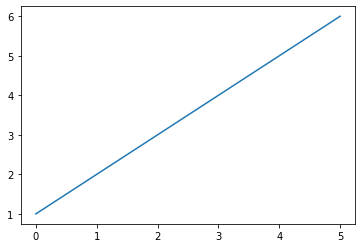

# 自动站的数据服务

ok 面雨量分别为:仙居县78.82毫米;天台县75.02毫米;三门县68.45毫米;临海市62.95毫米;黄岩区62.64毫米;温岭市47.34毫米;路桥区46.94毫米;椒江区40.8毫米;玉环市38.36毫米;玉环县23.84毫米;


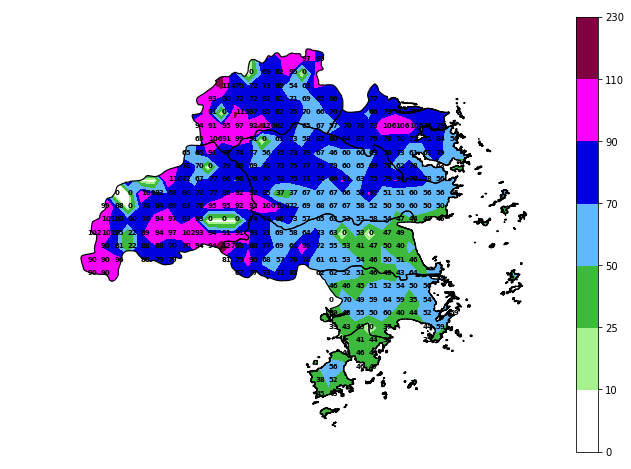

In [51]:
import base64
import json
import os
from io import BytesIO
from math import isnan

import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features

import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from func import *


class zdz_data:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        # 基础数据
        self.station_data = None
        self.day_list = None
        self.rain_line = None
        self.rain_scatter = None
        self.station_all = self.read_csv()
        self.img = None
        self.event_data()
        self.rain_data()
        #self.img = self.plot_img()
    def plot_img(self,lat,lon,value):
        #线性插值
        N = len(value)
        a = []
        b = []
        z = []
        for i in range(N):
            if value[i]!=-9999.0:
                a.append(round(lon[i],2))
                b.append(round(lat[i],2))
                z.append(round(value[i],2))
        lat = np.array(b)
        lon = np.array(a)
        Zi = np.array(z)
        data_max = max(Zi)
        data_min = min(Zi)
        np.set_printoptions(precision = 2)
        x = np.arange(120.0,122.0,0.05)
        #print(x)
        y = np.arange(27.8,29.5,0.05)
        nx0 =len(x)
        ny0 =len(y)
        X, Y = np.meshgrid(x, y)#100*100
        P = np.array([X.flatten(), Y.flatten() ]).transpose()    
        Pi =  np.array([lon, lat ]).transpose()
        Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
        #绘图
        colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
        levels = [0,10,25,50,70,90,110,230]
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[12,16]) 
    
        ax = fig.add_subplot(111)
        # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
        filepath = "shpfile/"
        data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
        shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,llcrnrlat=27.8,urcrnrlon=122,urcrnrlat=29.5,resolution = None, projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {'shrink': 0.5}    
        cs = data_xr.plot.contourf(ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
        m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        # labels = [left,right,top,bottom]
        #m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        #m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        plt.axis('off')
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.8+j*0.05,2)
                x0 = round(120.0+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
        basemask(cs, ax, m, filepath+'taizhou')  
        # 保存为base64数据
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd
    def sql_date(self):
        '''数据库读取sql数据'''
        print('读取数据库数据')
    def read_csv(self):
        '''
        1.数据读取---此方法为测试方法
        2.数据分段---每天
        3.每天统计
        '''
#         station_Mws = pd.read_csv("Mws_15.csv")
#         station_Aws = pd.read_csv("Aws_15.csv")
#         station_all = pd.concat([station_Aws, station_Mws])
        # station_all = pd.read_csv("data_zdz_height.csv")
        station_all = pd.read_csv("data_zdz_height.csv")
        return station_all
    def event_data(self):
        '''
        1.数据库查询
        2.数据分段---每天
        3.每天统计
        ['2022-04-14', 200,'高温 浓雾', '降水 大风', 200],
        '''
        dateList = []
        # 多少天
        dates = self.return_daylist()
        for i in dates:
            # 解析每天的数据
            # grouped_county = self.station_all.groupby('county')
            # grouped_IIiii = self.station_all.groupby('IIiii')
            # for i in self.grouped_county.size().index: 
            s_date = i + ' ' + '00:00'
            e_date = i + ' ' + '23:00'
            df_preday = self.station_all[(self.station_all['tTime'] >= s_date) & (self.station_all['tTime'] <= e_date)]
            #             df_RR= df_preday[df_preday['RR'] == -9999 ].count()
            #             grouped_county =
            date_preday = []
            # 日期
            day_date = str(i)
            # 面雨量
            rainfall = 200
            # 气温
            temp_min = df_preday[(df_preday['Height'] < 6000) & (df_preday['T'] > -400)]['T'].min()
            temp_min = temp_min / 10.0
            temp_max = df_preday[(df_preday['Height'] < 6000) & (df_preday['T'] > -400)]['T'].max()
            temp_max = temp_max / 10.0
            temp_label = ''
            if temp_min < 3.0:
                temp_label = '低温'
            elif temp_max > 35.0:
                temp_label = '高温'
            else:
                temp_label = ' '
            # 能见度
            # df_VV= df_preday[(df_preday['VV']>0.1)&(df_preday['VV']<500)]['VV'].count()
            vv = df_preday[(df_preday['VV'] > 0.1) & (df_preday['VV'] < 500)]['VV'].count()
            if vv > 0:
                view_label = '浓雾'
            else:
                view_label = ' '
                # 降水
            df_RR = df_preday[(df_preday['RR'] > 0.3) & (df_preday['RR'] < 8888)]['RR'].count()

            if df_RR > 0:
                pre_label = '降水'
            else:
                pre_label = ' '
            # 大风
            wind_count = df_preday[df_preday['fFy'] > 187]['fFy'].count()
            if wind_count > 0:
                wind_label = '大风'
            else:
                wind_label = ' '
            date_preday = [day_date, rainfall, temp_label + ' ' + view_label, pre_label + ' ' + wind_label, rainfall]
            dateList.append(date_preday)
        self.day_list = dateList
    #         print('event_data:返回一个每天的数组和日历所需的数据','气温',dateList)
    def return_daylist(self):
        '''
        返回每天的起始列表
        '''
        dates = []
        #         dt = datetime.datetime.strptime(self.start, "%Y-%m-%d")
        dt = dtt.datetime.strptime(self.start[0:10], "%Y-%m-%d")
        date = self.start[:10]
        while date <= self.end[:10]:
            dates.append(date)
            dt = dt + dtt.timedelta(1)
            date = dt.strftime("%Y-%m-%d")
        return dates
    def rain_data(self):
        '''
        1.根据起始时间计算面雨量的sql语句
        2.根据初始语句返回每站的总降水量
        '''
        station_all = self.station_all

        data_rain = {
            'rain_sum': {
                'time': [],
                'data': []
            },
            'IIiii_data': {}

        }
        
        grouped_tTime = station_all.groupby('tTime')
        for i in grouped_tTime.size().index:
            data = grouped_tTime.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            rain_mean = data['RR'].mean() / 10.0
            rain_time = i
            data_rain['rain_sum']['time'].append(rain_time)
            data_rain['rain_sum']['data'].append(rain_mean)
        # 导出单站数据
        grouped_IIiii = station_all.groupby('IIiii')
        rain_scatter = []
        #         {
        #          name: "K8515", value: [121.2, 28.6, 110],
        #          symbol: 'circle'
        #         }
        lat = []
        lon = []
        value = []
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            station_name = str(i)
            data_rain['IIiii_data'][station_name] = data
            single_data = {}
            single_data['name'] = station_name
            single_data['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['RR'].sum() / 10.0]
            lat.append(data['lat'].iloc[0])
            lon.append(data['lon'].iloc[0])
            value.append(data['RR'].sum())
            single_data['symble'] = 'circle'
            rain_scatter.append(single_data)
        self.station_data = data_rain['IIiii_data']
        self.rain_line = [data_rain['rain_sum']['time'], data_rain['rain_sum']['data']]
        self.rain_scatter = rain_scatter
        self.img = self.plot_img(lat,lon,value)
    def wind_data(self):
        '''
        1.根据sql语句计算8及以上大风的分布和排序
        '''
        data_wind_list = []
        station_all = self.station_all
        sort_data = {
            'IIiii': [],
            'county': [],
            'town': [],
            'value': []
        }
        # wind_max = station_all['fFy'].idxmax(axis=0)
        # station_max_name = station_all.iloc[wind_max,7]
        # station_max_data = self.station_data[station_max_name]
        grouped_IIiii = station_all.groupby('IIiii')
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            if data['fFy'].max() > 187:
                data_single = {}
                data_single['IIiii'] = data['IIiii'].iloc[0]
                data_single['county'] = data['county'].iloc[0]
                data_single['town'] = data['Town'].iloc[0]
                data_single['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].max() / 10.0]
                data_single['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                data_single['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                sort_data['IIiii'].append(data['IIiii'].iloc[0])
                sort_data['county'].append(data['county'].iloc[0])
                sort_data['town'].append(data['Town'].iloc[0])
                sort_data['value'].append(data['fFy'].max() / 10.0)
                data_wind_list.append(data_single)
        # 对数据进行排序
        max_sort = max(sort_data['value'])
        level_sort = np.linspace(start=0.0, stop=max_sort, num=9)
        sort_data = pd.DataFrame(sort_data)
        sort_data['index'] = sort_data['value'].rank(ascending=0, method='dense')
        sort_out = sort_data.sort_values(by=['value'], ascending=[False])
        sort_html = ''
        # <tr><th>排序</th><th>乡镇</th><th>站点</th><th>能见度</th></tr>
        for i in sort_out['index']:
            table_html = '<tr><th>' + str(int(i)) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['town'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['IIiii'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['value'].iloc[0]) + '</th></tr>'
            sort_html = sort_html + table_html
        return data_wind_list, sort_html
    def view_data(self):
        '''
        1.根据sql语句计算低能见度的分布和排序
        '''
        '''
        1.根据sql语句计算8及以上大风的分布和排序
        '''
        data_view_list = []
        station_all = self.station_all
        sort_data = {
            'IIiii': [],
            'county': [],
            'town': [],
            'value': []
        }
        # wind_max = station_all['fFy'].idxmax(axis=0)
        # station_max_name = station_all.iloc[wind_max,7]
        # station_max_data = self.station_data[station_max_name]
        grouped_IIiii = station_all.groupby('IIiii')
        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            if data['fFy'].max() > 187:
                data_single = {}
                data_single['IIiii'] = data['IIiii'].iloc[0]
                data_single['county'] = data['county'].iloc[0]
                data_single['town'] = data['Town'].iloc[0]
                data_single['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].max() / 10.0]
                data_single['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                data_single['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                sort_data['IIiii'].append(data['IIiii'].iloc[0])
                sort_data['county'].append(data['county'].iloc[0])
                sort_data['town'].append(data['Town'].iloc[0])
                sort_data['value'].append(data['fFy'].max() / 10.0)
                data_view_list.append(data_single)
        # 对数据进行排序
        max_sort = max(sort_data['value'])
        level_sort = np.linspace(start=0.0, stop=max_sort, num=9)
        sort_data = pd.DataFrame(sort_data)
        sort_data['index'] = sort_data['value'].rank(ascending=0, method='dense')
        sort_out = sort_data.sort_values(by=['value'], ascending=[False])
        sort_html = ''
        # <tr><th>排序</th><th>乡镇</th><th>站点</th><th>能见度</th></tr>
        for i in sort_out['index']:
            table_html = '<tr><th>' + str(int(i)) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['town'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['IIiii'].iloc[0]) + '</th><th>' + \
                         str(sort_out[sort_out['index'] == i]['value'].iloc[0]) + '</th></tr>'
            sort_html = sort_html + table_html
        return data_view_list, sort_html
    def temp_data(self):
        '''
        1.根据sql语句计算高低温的分布和排序
        '''
#         temp_station_list = [
#             "58559","K8705","K8706","58652","58653","K8903","58568","K8818","58662","K8821",
#             "58660","K8609","K8282","58665","K8217","K8201","58661","58665","K8301","58663",
#             "58664","K8413","58666","58669","K8611","K8505","58667","58668"
#         ]
        temp_station_list = [
            "K8705","K8706","K8903","K8818","K8821",
            "K8609","K8282","K8217","K8201","K8301",
            "K8413","K8611","K8505"
        ]
        data_temp_max = []
        data_temp_min = []
        for i in temp_station_list:
            single_data_max = {}
            single_data_min = {}
            station_name = i
            single_data_max['name'] = i
            single_data_max['value'] = [self.station_data[i]['lon'].iloc[0], self.station_data[i]['lat'].iloc[0],
                                        self.station_data[i]['T'].max() / 10.0]
            single_data_min['name'] = i
            single_data_min['value'] = [self.station_data[i]['lon'].iloc[0], self.station_data[i]['lat'].iloc[0],
                                        self.station_data[i]['T'].min() / 10.0]
            data_temp_max.append(single_data_max)
            data_temp_min.append(single_data_min)
        return data_temp_max, data_temp_min
    def pre_day(self, date):
        '''
        日报的响应时间、触发后统计对应天的灾情
        '2022-04-14', 200,'高温 浓雾', '降水 大风', 
        '''
        # date = ['2022-04-14', 200,'低温 浓雾', '降水 大风', 200]
        # 计算时间
        today = dtt.datetime.strptime(date, '%Y-%m-%d')
        start_time = str(today + datetime.timedelta(days=-1))[0:10] + ' 20:00'
        end_time = str(today + datetime.timedelta(days=1))[0:10] + ' 08:00'
        data_all = self.station_all
        data_time = data_all[(data_all['tTime'] >= start_time) & (data_all['tTime'] <= end_time)]

        grouped_IIiii = data_time.groupby('IIiii')
        # 所需数据库
        pre_list = []
        wind_list = []
        view_list = []
        tmax_list = []
        tmin_list = []

        for i in grouped_IIiii.size().index:
            data = grouped_IIiii.get_group(i)
            # print(data)   
            # 低温
            if data[data['T'] > -999]['T'].min() < 30:
                tmin_dir = {}
                tmin_dir['name'] = data['IIiii'].iloc[0]
                tmin_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['T'].tolist(), data['T'].min()]
                tmin_list.append(tmin_dir)
            # 高温   
            if data['T'].max() > 350:
                tmax_dir = {}
                tmax_dir['name'] = data['IIiii'].iloc[0]
                tmax_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['T'].tolist(), data['T'].max()]
                tmax_list.append(tmax_dir)
            # 大风
            if data[data['fFy'] > 187]['fFy'].max():
                wind_dir = {}
                wind_dir['name'] = data['IIiii'].iloc[0]
                wind_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['fFy'].tolist(), data['fFy'].max()]
                wind_dir['symbol'] = 'path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z'
                wind_dir['symbolRotate'] = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
                wind_list.append(wind_dir)
            # 能见度
            if data[(data['VV'] < 500) & (data['VV'] > 0)]['VV'].min():
                view_dir = {}
                view_dir['name'] = data['IIiii'].iloc[0]
                view_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['VV'].tolist(), data['VV'].min()]
                view_list.append(view_dir)
                # 降水
            if data['RR'].max() > 0:
                pre_dir = {}
                data['RR'].replace(-9999, np.nan, inplace=True)
                pre_dir['name'] = data['IIiii'].iloc[0]
                pre_dir['value'] = [data['lon'].iloc[0], data['lat'].iloc[0], data['tTime'].tolist(),
                                    data['RR'].tolist(), data['RR'].sum()]
                pre_dir['symble'] = "circle"
                pre_list.append(pre_dir)
        return pre_list
    def text_data(self):
        '''用来处理风雨情统计数据'''
        start_time = start 
        end_time = end
        time_len =len(pd.date_range(start=start_time,end=end_time,freq='1H')) 
        station_all = self.station_all 
        # 计算面雨量
        grouped_county = station_all.groupby('county')        
        # 所需数据库
        pre_county = { }
        ## 
        iii_pre = {}
        iii_pre_data = {}
        iii_tmin_data = {}
        iii_tmax_data = {}
        iii_vvmin_data = {}
        iii_fmax_data = {}
        ##
        town_pre_data = {}
        # 面雨量   
        for i in grouped_county.size().index:
            data = grouped_county.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            ave = data['RR'].mean() * time_len /10.0
            pre_county[data['county'].iloc[0]] = ave
        #逐站统计    
        grouped_iii = station_all.groupby('IIiii') 
        for i in grouped_iii.size().index:
            data = grouped_iii.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            data['VV'].replace(-9999, np.nan, inplace=True)
            data['fFy'].replace(-9999, np.nan, inplace=True)
            data['T'].replace(-9999, np.nan, inplace=True)
            # 存储变量
            iii_pre_data[data['IIiii'].iloc[0]] =  data['RR'].sum()/10.0 # 累计降水
            iii_tmin_data[data['IIiii'].iloc[0]] =  data['T'].min()      # 高温
            iii_tmax_data[data['IIiii'].iloc[0]] =  data['T'].max()      # 低温
            iii_vvmin_data[data['IIiii'].iloc[0]] =  data['VV'].min()    # 能见度
            iii_fmax_data[data['IIiii'].iloc[0]] =  data['fFy'].max()    # 风力
        # 乡镇排序
        grouped_town = station_all.groupby('Town') 
        for i in grouped_town.size().index:
            data = grouped_town.get_group(i)
            data['RR'].replace(-9999, np.nan, inplace=True)
            town_pre_data[data['Town'].iloc[0]] =  data['RR'].sum()/10.0    
        # 文字排序的基本逻辑
        # 1. 降水
        # 2. 高低温
        # 3. 能见度
        # 4. 风
        # 5. 小时雨强
        ## 乡镇降水排序
        town_pre_sort = sorted(town_pre_data.items(), key=lambda x: x[1])
        town_pre_text = "乡镇前五：" + town_pre_sort[-1][0] + "：" + str(town_pre_sort[-1][1]) + "毫米,"\
            + town_pre_sort[-2][0]+ "：" + str(town_pre_sort[-2][1]) + "毫米,"\
            + town_pre_sort[-3][0]+ "：" + str(town_pre_sort[-3][1]) + "毫米,"\
            + town_pre_sort[-4][0]+ "：" + str(town_pre_sort[-4][1]) + "毫米,"\
            + town_pre_sort[-5][0]+ "：" + str(town_pre_sort[-5][1]) + "毫米."
        ## 降水排序
        iii_pre_sort = sorted(iii_pre_data.items(), key=lambda x: x[1])
        iii_pre_text = "单站前五：" + iii_pre_sort[-1][0] + "：" + str(iii_pre_sort[-1][1]) + "毫米,"\
            + iii_pre_sort[-2][0]+ "：" + str(iii_pre_sort[-2][1]) + "毫米,"\
            + iii_pre_sort[-3][0]+ "：" + str(iii_pre_sort[-3][1]) + "毫米,"\
            + iii_pre_sort[-4][0]+ "：" + str(iii_pre_sort[-4][1]) + "毫米,"\
            + iii_pre_sort[-5][0]+ "：" + str(iii_pre_sort[-5][1]) + "毫米."
        ## 降水站点个数
        iii_pre_count = len({k:v for k, v in iii_pre_data.items() if v>=50}.items())
        
        ## 面雨量
        county_text = "面雨量分别为:"
        for single in sorted(pre_county.items(), key=lambda x: x[1], reverse=True):
            single_text = single[0]+ "" + str(round(single[1],2)) + "毫米;"
            county_text = county_text + single_text        
        print("ok",county_text)
        # 输出文档内容
        
        

start = '2022-01-25 20:00'
end = '2022-02-10 06:00'

zdz_worker = zdz_data(start, end)
zdz_worker.text_data()
# context = {
#     'status': "ok",
#     'day_list': zdz_worker.day_list,
#     'day_range': [zdz_worker.day_list[0][0], zdz_worker.day_list[-1][0]],
#     'rain_line': zdz_worker.rain_line,
#     'rain_scatter': json.dumps(zdz_worker.rain_scatter),
#     'rain_img':zdz_worker.img
#     }

In [46]:
# 字典排序
a = {'a': 5, 'c': 4, 'b':3, 'd': 34}
# 按照字典的值进行排序
a1 = sorted(a.items(), key=lambda x: x[1])
# 按照字典的键进行排序
# a2 = sorted(a.items(), key=lambda x: x[0])
# print('按值排序后结果', a1)
# print('按键排序后结果', a2)
# print('结果转为字典格式', dict(a1))
# print('结果转为字典格式', dict(a2))
# [('b', 3), ('c', 4), ('a', 5), ('d', 34)]
# a1[-2][0]

# 统计个数
# test_dict = {1:5, 2:4, 3:3, 4:2, 5:1}
# print({k:v for k, v in test_dict.items() if k>=3})
# len(test_dict.items())

# 字符串格式化
d = {"a":1,"b":2 } 
for dict_key, dict_value in d.items():
    
    print(dict_key,'->',dict_value)

a -> 1
b -> 2


# 自动站基础数据的返回和计算

In [ ]:
station_list = [
    "58559","K8705","K8706","58652","58653","K8903","58568","K8818","58662","K8821",
    "58660","K8609","K8282","58665","K8217","K8201","58661","58665","K8301","58663",
    "58664","K8413","58666","58669","K8611","K8505","58667","58668"
]
